In [7]:
"""

# Plotting the stable BH mass distribution for several SFRD Z-distribution variations

"""
import matplotlib
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import h5py as h5 
from astropy.table import Table
import astropy.units as u
from astropy import constants as const

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

import json
import argparse
import os

# Custum scripts
sys.path.append( str(os.getcwd()) + '/../')
import MassDistHelperFunctions as mfunc
import paths
import init_values as In
import Plot_Mass_distributions as pltmass

######################################
## locations
save_loc    =  str(paths.figures) + '/'
data_dir    =  str(paths.data) + '/'


######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


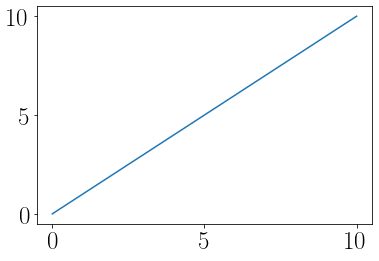

In [8]:
plt.plot(np.linspace(0,10), np.linspace(0,10))
plt.show()


In [18]:
######################################
# Distribution plot function
######################################
def plot_mass_distribution(sim_dir = '', rate_file = '', simulation_data = '', 
                    x_key = 'M_moreMassive', rate_keys = ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma0%s_sigmaz0.05_zBinned'%(x) for x in [0.8, 1.125, 1.4]],channel_string = 'all',
                   bins = np.arange(0.,55,2.5), z_bin_edges = [0,0.25], 
                   plot_LIGO = False, show_hist = False, show_KDE = True,   
                   only_stable = True, only_CE = True, 
                   bootstrap = False, bootstraps = 10, x_lim=(0.,50),  y_lim = (1e-2,30), 
                   Color = '#e388b0', linestyles = ['--','-', ':'], titletext = '',
                   labels = [r'$\mathrm{CE \ channel = \ }$', r'$\mathrm{stable \ RLOF \ channel = \ }$', r'$\mathrm{All = \ }$'],
                   xlabel = r'$M_{\mathrm{BH, 1}} \ \rm [M_{\odot}]$', ylabel = r'$\frac{d\mathcal{R}}{dM_{\mathrm{BH, 1} }} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                   leg_args = {'loc':'lower left',  'bbox_to_anchor':[0.1, 0.], 'fontsize':20, 'title':''}, leg1_args = {'loc':'upper left', 'fontsize':18},
                   save_plot=False, save_name = 'Fiducial.png', multipanel = False, subplot = None):
    """
    Read DCO, SYS and merger rate data, necesarry to make the plots in this 

    Args:
        sim_dir              --> [string] Location of data

    Returns:
     plot

    """
    #########################################
    mass_binw = np.diff(bins)[0]
    plot_lines = []
    leg_labels = []

    #########################################
    # Start plotting
#     if not multipanel: #(otherwise you define the Fig outside of this fucntion)
    fig, ax = plt.subplots(figsize = (12, 10))
#     else:
#         ax = subplot

    ################################################
    # GWTC-3 Powerlaw + Peak Mass distribution
    ################################################ 
    if plot_LIGO:
        print('plotting LIGO')
        color_plpeak = 'grey'#'#1f78b4'
        #################################################
        ## grab Powerlaw + Peak data from O3
        #################################################  
        #'/Volumes/StorageSpac/CompasOutput/output/'#'/n/home04/lvanson/LowMBH_peak/output/GWTC-3-population-data/analyses/PowerLawPeak/'
        input_fname = data_dir+'o3only_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
        mass_1 = np.linspace(2, 100, 1000)
        mass_ratio = np.linspace(0.1, 1, 500)
        with h5.File(input_fname, "r") as f:
            mass_ppd = f["ppd"]
            mass_lines = f["lines"]
            mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
            mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
            mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
        ##############################
        # plot the max posterior and the 95th percentile
        ax.plot(mass_1, mass_1_ppd, lw=1.8, color=color_plpeak, zorder=1, label="$\mathrm{GWTC-3}$")
        ax.fill_between(mass_1, mass_1_lower, mass_1_upper, alpha=0.14,color=color_plpeak,zorder=0)

        legend1 = plt.legend(**leg1_args)

    nplot = 0

    ################################################
    # My Simulations
    ################################################
    DCO = mfunc.read_data(loc = sim_dir + '/' + simulation_data)

    # We'll show the change in rate between SFRD at several reference masses
    m10, m25, m40 = [], [], []

    print('nplot', nplot, '\n')
    ####################################################
    ### Loop over SFRD
    for i, rate_key in enumerate(rate_keys):
        print('rate_key', rate_key)

        # ### ## Reading Rate data ##
        with h5.File(sim_dir + '/' + rate_file ,'r') as File:
            print('FILE KEYS!!', File.keys())
            redshifts                 = File[rate_key]['redshifts'][()]
            # Different per rate key:
            DCO_mask                  = File[rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
            #(contains filter for RLOF>CE and optimistic CE)
            intrinsic_rate_density    = File[rate_key]['merger_rate'][()]

        #############################
        print('start masking data')    
        # Older simulations use this naming
        CEcount = 'CE_Event_Count'                # Old simulations use this
        if CEcount in DCO.columns:
            print('using file with key', CEcount)
        else:
            print('using file with key', CEcount)
            CEcount = 'CE_Event_Counter'          # Newer simulations use this

        # # # # # # # # # # # # # # # # # # 
        #first bring it to the same shape as the rate table
        merging_BBH    = DCO[DCO_mask]
        #apply the additional mask based on your prefs
        if np.logical_and(only_stable, only_CE):
            print("Both only_stable and only_CE, I assume you just want both")
            channel_bool = np.full(len(merging_BBH), True)
        elif only_stable:
            channel_bool = merging_BBH[CEcount] == 0
        elif only_CE:
            channel_bool = merging_BBH[CEcount] > 0
        else:
            raise ValueError("Both only_stable =%s and only_CE=%s, set at least one to true"%(only_stable,only_CE))
        # we exclude CHE systems
        not_CHE  = merging_BBH['Stellar_Type@ZAMS(1)'] != 16
        BBH_bool = np.logical_and(merging_BBH['Stellar_Type(1)'] == 14, merging_BBH['Stellar_Type(2)'] == 14)
        print('BBH_bool should already contain all stuff, np.sum(BBH_bool) ', np.sum(BBH_bool), ' len(merging_BBH)', len(merging_BBH))

        #################
        merging_BBH         = merging_BBH[BBH_bool * not_CHE  * channel_bool]
        Red_intr_rate_dens  = intrinsic_rate_density[BBH_bool* not_CHE * channel_bool, :]


        # # # # # # # # # # # # # # # # # # 
        ## Calculate average rate density per z-bin
        #########################################
        print('grad rate at redshift 0.2')
        x_vals              = merging_BBH[x_key]
        i_redshift = np.where(redshifts == 0.2)[0][0]
        print('i_redshift', i_redshift)
        Weights             = Red_intr_rate_dens[:, i_redshift]#crude_rate_density[:,0]
        print(labels[i], ' len(merging_BBH)=', len(merging_BBH) , ' Rate = ', np.sum(Weights), ' Gpc-3 yr-1')

        ########################
        # Get the Hist    
        print('get the hist')
        hist, bin_edge = np.histogram(x_vals, weights = Weights, bins=bins)
        y_vals = hist/mass_binw
        center_bins = (bin_edge[:-1] + bin_edge[1:])/2.

        # And the KDE
        kernel = stats.gaussian_kde(x_vals, bw_method='scott', weights=Weights)
        binwidth = np.diff(bin_edge)

        m10.append(kernel(10)*sum(hist)) # append value at reference mass 
        m25.append(kernel(25)*sum(hist)) # append value at reference mass 
        m40.append(kernel(40)*sum(hist)) # append value at reference mass 

        ########################
        # Plot the Hist 
        if show_hist:
            plot_lines.append(ax.step(center_bins, y_vals,  where='mid',label = None,#labels[i]+'$%s \mathrm{ \ Gpc^{-3} yr^{-1}}$'%(np.round(np.sum(Weights),1)) , 
                                      alpha=1.0, lw = 3.5, zorder = i, color= Color, 
                                      marker = 'o', markersize = 15) ) #edgecolor=color[i],
            # to prevent overflowing
            min_xkde = min(center_bins[y_vals>5e-4])

        ########################
        # Add KDE
        if show_KDE:
            x_KDE = np.arange(0.1,50.,0.1)
            KDEy_vals =  kernel(x_KDE)*sum(hist) #re-normalize the KDE
            leg_labels.append(labels[nplot]+'$%s$'%(np.round(np.sum(Weights),1)))

            if not show_hist:
                plot_lines.append(ax.plot(x_KDE, KDEy_vals, label = '', color=Color, lw= 5,  zorder =i+1,ls = linestyles[nplot]))

        #     ########################
        #     # Bootstrap   
        #     if bootstrap:
        #         indices = np.arange(len(x_vals))
        #         hist_vals = np.zeros((bootstraps, len(x_KDE)))  #center_bins
        #         for b in progressbar( range(len(hist_vals)), "Bootstrapping "+ labels[i] + ":"):
        #             boot_index = np.random.choice(indices, size=len(indices), replace=True)
        #             kernel         = stats.gaussian_kde(x_vals[boot_index], bw_method=kde_width, weights=Weights[boot_index])
        #             Hist, _        = np.histogram(x_vals[boot_index], bins=bins, weights=Weights[boot_index],density=False)
        #             hist_vals[b]   = kernel(x_KDE)*sum(Hist)

        #         # calculate 1- and 2- sigma percentiles
        #         y_vals = hist_vals#/mass_binw

        #         percentiles = np.percentile(y_vals, [10., 90.], axis=0)
        #         print('nplot',nplot, 'np.shape(percentiles)', np.shape(percentiles))
        #         ax.fill_between(x_KDE, percentiles[0],percentiles[1], alpha=0.4, color=Color, zorder = 11) # 1-sigma

        nplot += 1


    #########################################
    # Show the variation in SFR at 3 different masses
#     reference_masses = [10, 25, 40]
#     for m, mpoint in enumerate([m10, m25, m40]):
#         print('m', np.median(mpoint), max(mpoint), min(mpoint))
#         print()
#         ax.vlines(x=reference_masses[m], ymin=min(mpoint), ymax=max(mpoint), colors='k', lw=3, zorder = 20)
#         ax.hlines(y=[min(mpoint), max(mpoint)], xmin=reference_masses[m]-0.5, xmax=reference_masses[m]+0.5, linewidth=3, color='k', zorder = 20)
#         ax.text(reference_masses[m] - 0.7, (max(mpoint)+min(mpoint))/2 , r'%s $\times $'%(np.round( (max(mpoint)/min(mpoint))[0] , 1)), 
#             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha = 0.5), clip_on=True, ha = 'right', size = 25, zorder = 20)

    #########################################
    # plot values
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    # SFRD variaton
    plt.text(0.63, 0.85, titletext, ha = 'center', transform=ax.transAxes, size = 25)
    # Channel
    plt.text(0.75, 0.66, '$\mathrm{%s \ channel}$'%(channel_string), ha = 'center', transform=ax.transAxes, size = 29)

    #####
    # add legend for simulations
    leg = ax.legend(**leg_args)
    leg = plt.legend([l[0] for l in plot_lines], [l for l in leg_labels ],  **leg_args)
    leg.set_zorder(102)
    leg._legend_box.align = "right"

    # Legend for GWTC-3
    if plot_LIGO:
        plt.gca().add_artist(legend1)

    s = ['$[%s \leq z < %s]$'%(z_bin_edges[a],z_bin_edges[a+1]) for a in range(0,len(z_bin_edges)-1)]   

    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)

    ax.set_yscale('log')
    fig.savefig(paths.data / 'miscFigures/Fid.pdf',  bbox_inches='tight', dpi=300)

    plt.show()
    
#     if not multipanel:
#         if save_plot:
#             plt.savefig(save_loc+'/'+save_name , bbox_inches='tight')

#         plt.show()
#         # clear memory
#         gc.collect()
#     else:
#         return ax




making Figure  /Users/lieke/surfdrive/Documents/SFRD_fit/src/tex/figures//Mass_distributions_stable_SFRD_variations.pdf
plotting LIGO
using file with key DoubleCompactObjects
Done with reading DCO data for this file :)
nplot 0 

rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned
FILE KEYS!! <KeysViewHDF5 ['BSE_Common_Envelopes', 'BSE_Double_Compact_Objects', 'BSE_RLOF', 'BSE_Supernovae', 'BSE_System_Parameters', 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned', 'Run_Details']>
start masking data
using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1835145
grad rate at redshift 0.2
i_redshift 4
$\mathrm{Fiducial: \ } (\omega_0 = 1.13) \ \mathcal{R}_{0.2}= \ $  len(merging_BBH)= 449453  Rate =  20.319124460976614  Gpc-3 yr-1
get the hist


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:226: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


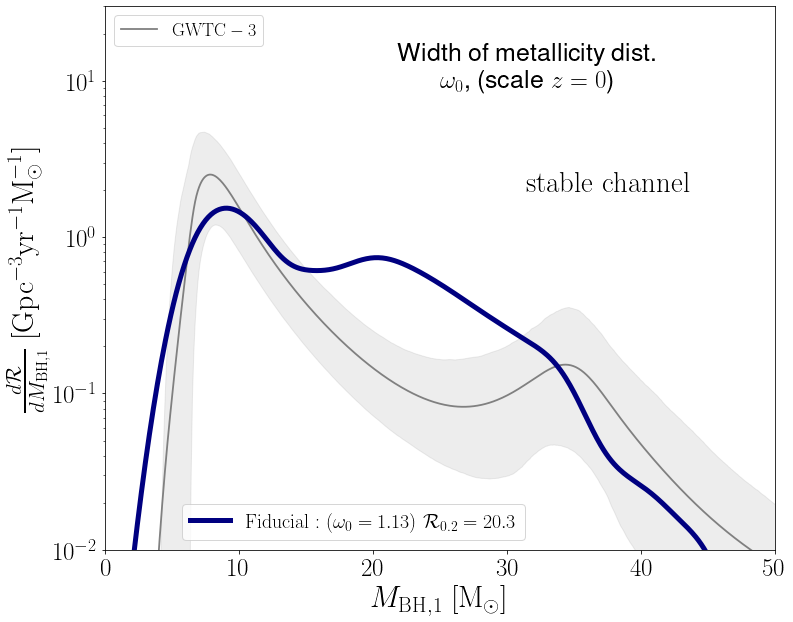

In [22]:
# Initialize values
In.init()

only_stable = True
only_CE     = False
channel_string = 'stable'

print('making Figure ', save_loc + '/Mass_distributions_'+ channel_string+'_SFRD_variations.pdf')

plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(In.COMPASfilename),#'/RateData/'+str(In.rate_file_name), 
                             simulation_data = '/'+str(In.COMPASfilename),
                       x_key = 'M_moreMassive',  rate_keys  = ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned'],
#                        ['Rates_mu00.025_muz-0.049_alpha-1.79_sigma0%s_sigmaz0.048_a0.017_b1.487_c4.442_d5.886'%(x) for x in [1.129]],
                             channel_string = channel_string,linestyles = ['-'], 
                       show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',
                       only_CE = only_CE, only_stable = only_stable, 
                       bootstrap = False, bootstraps = 50, save_name = 'test_fid_rate.pdf', titletext = "Width of metallicity dist."+"\n"+r"$\omega_0$, (scale $z=0$)",
                       labels = [r'$\mathrm{Fiducial: \ } (\omega_0 = 1.13) \ \mathcal{R}_{0.2}= \ $'],
                      multipanel = False)
# ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned'],#
